In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from keras_yamnet import params
from keras_yamnet.yamnet import YAMNet
from keras_yamnet.preprocessing import preprocess_input
from keras_yamnet.postprocessing import postprocess_output
import tensorflow as tf

import soundfile as sf
import os
import platform
import time
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import h5py
from sklearn.utils import shuffle
from sed_eval.sound_event import EventBasedMetrics, SegmentBasedMetrics
from dataset import conversion_functions as cf
import settings


In [2]:
def save_arrays_to_cache(x, y, cache_file):
    with h5py.File(cache_file, 'w') as f:
        dset_x = f.create_dataset('x', shape=x.shape, dtype=x.dtype)
        dset_y = f.create_dataset('y', shape=y.shape, dtype=y.dtype)
        for i in tqdm(range(x.shape[0]), desc='Saving x to cache'):
            dset_x[i] = x[i]
        for i in tqdm(range(y.shape[0]), desc='Saving y to cache'):
            dset_y[i] = y[i]

def load_arrays_from_cache(cache_file):
    with h5py.File(cache_file, 'r') as f:
        x = f['x'][:]
        y = f['y'][:]
    return x, y

def load_features_and_labels_from_cache(gt_path, audios_folder):

    cache_file = os.path.splitext(gt_path)[0] + '.npz'

    if os.path.exists(cache_file) and not settings.FORCE_RELOAD_TRAIN:
        print(f"Loading cached result from {cache_file} ...")
        x, y = load_arrays_from_cache(cache_file)
    else:
        print(f'Processing and caching in : {cache_file}')
        x, y = load_features_and_array_labels(gt_path, audios_folder)
        save_arrays_to_cache(x, y, cache_file)

    return x, y

def load_features_and_array_labels(gt_path, audios_folder):
    """
    Load training data from ground truth file and preprocess it.

    Args:
        gt_file (pd.DataFrame): DataFrame containing ground truth data.
    Returns:
        input_array (np.ndarray): Array of preprocessed audio data patches.
        output_array (np.ndarray): Array of target outputs corresponding to the audio data. 
            Contains targets that are one-hot encoded vectors for each class.
    """
    gt_file = pd.read_csv(gt_path, sep='\s+')

    audiofile_to_detection = {}  
    audiofile_to_patches = {}  
    class_to_count = {key: 0 for key in settings.CLASS_NAMES}
    n_detections = 0

    for _, row in tqdm(gt_file.iterrows(), total=len(gt_file), desc='Loading gt'):
        audiofile = row['filename']

        starttime = row['start_time']
        endtime = row['end_time']
        class_name = row['class']

        patch_index_start = cf.second_to_index(starttime)
        patch_index_end = cf.second_to_index(endtime)
        class_idx = cf.class_name_to_index(class_name)

        if class_name in settings.CLASS_NAMES:
            class_to_count[class_name] += 1

        n_detections += 1

        if audiofile not in audiofile_to_detection:
            audio_path = os.path.join(audios_folder, audiofile)
            audio_wave, sample_rate = sf.read(audio_path)
            data_patches, _ = preprocess_input(audio_wave, sample_rate)
            audiofile_to_patches[audiofile] = data_patches

            pred = np.zeros((len(data_patches), settings.N_CLASSES), dtype=np.float32)
            pred[patch_index_start:patch_index_end+1, class_idx] = settings.GT_CONFIDENCE
            audiofile_to_detection[audiofile] = pred

        else:
            audiofile_to_detection[audiofile][patch_index_start:patch_index_end, class_idx] = settings.GT_CONFIDENCE

    print(f'Count of detections among classes: {class_to_count}, out of a total of {n_detections} detections')
    
    input_array = []
    output_array = []

    for audiofile in audiofile_to_detection: 
        data_patches = audiofile_to_patches[audiofile]
        pred = audiofile_to_detection[audiofile]

        input_array.append(data_patches)
        output_array.append(pred)
        
    input_array = np.concatenate(input_array, axis=0)  # shape: (num_patches, PATCH_FRAMES, n_bands)
    output_array = np.concatenate(output_array, axis=0)  # shape: (num_patches, N_CLASSES)
    
    return input_array, output_array

def visualize_and_save_history(history, timestamp):
    """
    Visualize training history.
    
    Args:
        history (tf.keras.callbacks.History): History object containing training metrics.
    """

    fig, axs = plt.subplots(2, 1, figsize=(12, 10))

    # Loss subplot
    axs[0].plot(history.history['loss'], label='Training Loss', color='#003366')  # Dark blue
    axs[0].plot(history.history['val_loss'], label='Validation Loss', color='#66b3ff')  # Light blue
    axs[0].set_title('Training and Validation Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].set_ylim(0, 1.5)
    axs[0].legend()
    axs[0].grid()

    # F1-SCORE  subplot
    axs[1].plot(history.history['f1_score'], label='Training f1-score', color='#006400')  # Dark green
    axs[1].plot(history.history['val_f1_score'], label='Validation f1-score', color='#90ee90')  # Light green
    axs[1].set_title('Training and Validation f1-score')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('f1-score')
    axs[1].set_ylim(0, 1)
    axs[1].legend()
    axs[1].grid()

    plt.tight_layout()
    plt.show()

    os.makedirs('history', exist_ok=True)
    os.makedirs(f'history/{timestamp}', exist_ok=True)
    fig.savefig(f'history/{timestamp}/history.png')

def predictions_to_event_list(predictions):
    """
    Convert model predictions to a list of detected events compatible with sed_eval.
    Assumes predictions are binary (0 or 1) for each class at each segment.
    """
    output = []
    predictions = np.array(predictions)
    num_segments, num_classes = predictions.shape

    for i in range(num_segments):
        for class_idx, score in enumerate(predictions[i]):
            if score == 1:
                output.append({
                    'file': 'an_audio',
                    'event_label': settings.CLASS_NAMES[class_idx],
                    'onset': i * params.PATCH_WINDOW_SECONDS,
                    'offset': (i + 1) * params.PATCH_WINDOW_SECONDS
                })

    return output

def print_metrics(metrics, title):
    print(f"\n{title}")
    overall = metrics['overall']
    print(f"  F1: {overall['f_measure']['f_measure']:.3f} | Precision: {overall['f_measure']['precision']:.3f} | Recall: {overall['f_measure']['recall']:.3f}")
    print(f"  Error Rate: {overall['error_rate']['error_rate']:.3f}")
    if 'accuracy' in overall and overall['accuracy']:
        acc = overall['accuracy'].get('accuracy', None)
        if acc is not None:
            print(f"  Accuracy: {acc:.3f}")
    print("  Class-wise F1:")
    for cls, vals in metrics['class_wise'].items():
        f1 = vals['f_measure']['f_measure']
        print(f"    {cls}: {f1:.3f}")

def get_data_from_dict(data_dict):
    X = None
    y = None

    for gt_path, audios_folder in data_dict.items():

        X_temp, y_temp = load_features_and_labels_from_cache(gt_path, audios_folder)

        if X is None and y is None:
            X = X_temp
            y = y_temp
        else:
            X = np.concatenate((X, X_temp), axis=0)
            y = np.concatenate((y, y_temp), axis=0)

    X, y = shuffle(X, y, random_state=42)

    return X, y

def get_device():
    # 1) NVIDIA GPU (Windows/Linux/macOS w/ eGPU): fastest if available
    if torch.cuda.is_available():
        return torch.device("cuda"), "cuda"

    # 2) Apple Silicon GPU (macOS M1/M2/M3)
    if platform.system() == "Darwin" and torch.backends.mps.is_available():
        # Optional: allow silent CPU fallback for unsupported ops on MPS
        os.environ.setdefault("PYTORCH_ENABLE_MPS_FALLBACK", "1")
        return torch.device("mps"), "mps"

    # 3) DirectML (Windows + AMD/Intel/NVIDIA via the 'torch-directml' package)
    #    pip install torch-directml   (import torch_directml)  -> a separate package
    try:
        if platform.system() == "Windows":
            import torch_directml  # noqa: F401
            dml = torch_directml.device()
            return dml, "directml"
    except Exception:
        pass

    # 4) CPU fallback (works everywhere)
    return torch.device("cpu"), "cpu"


In [3]:
device, device_type = get_device()
print(f"Using device: {device_type}")

Using device: mps


In [4]:

X_train, y_train = get_data_from_dict(settings.data_pairs_train)

X_test, y_test = get_data_from_dict(settings.data_pairs_test)


Processing and caching in : /Users/ingeborgborhaug/Skole/Prosjektoppgave/sound-event-detection-aircrafts/dataset/AeroSonicDB/gt_train.npz


Loading gt: 100%|██████████| 1052/1052 [00:36<00:00, 29.12it/s]


Count of detections among classes: {'Aircraft': 1052}, out of a total of 1052 detections


Saving y to cache: 100%|██████████| 121928/121928 [00:02<00:00, 51039.13it/s]


Processing and caching in : /Users/ingeborgborhaug/Skole/Prosjektoppgave/sound-event-detection-aircrafts/dataset/AeroSonicDB/gt_test.npz


Loading gt: 100%|██████████| 198/198 [00:05<00:00, 37.64it/s]


Count of detections among classes: {'Aircraft': 198}, out of a total of 198 detections


Saving y to cache: 100%|██████████| 23364/23364 [00:00<00:00, 50475.06it/s]


In [5]:
yamnet_model_name = 'keras_yamnet/yamnet.h5'
yamnet_model = YAMNet(weights=yamnet_model_name)
base_model = tf.keras.Model(
    inputs=yamnet_model.input,
    outputs=yamnet_model.get_layer('global_average_pooling2d').output
)
yamnet_model.trainable = False
base_model.trainable = False

# Extract embeddings using YAMNet (TensorFlow/Keras)
X_embeddings_train = base_model.predict(X_train, verbose=1)
X_embeddings_test = base_model.predict(X_test, verbose=1)


731/731 [==============================] - 24s 33ms/step


In [6]:

class ModifiedModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, num_classes)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x
    
model = ModifiedModel(input_dim=X_embeddings_train.shape[1], num_classes=settings.N_CLASSES).to(device)

# Prepare PyTorch datasets and loaders
X_train_tensor = torch.tensor(X_embeddings_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# Validation split
val_split = getattr(settings, "VAL_SIZE", 0.2)
num_val = int(len(X_train_tensor) * val_split)
indices = np.arange(len(X_train_tensor.cpu()))
np.random.shuffle(indices)
val_indices = indices[:num_val]
train_indices = indices[num_val:]
X_val_tensor = X_train_tensor[val_indices]
y_val_tensor = y_train_tensor[val_indices]
val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)


In [7]:

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 300
patience = 20
best_loss = float('inf')
epochs_no_improve = 0
best_state = None
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        best_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

model.load_state_dict(best_state)

# SAVE MODEL 
timestr = time.strftime("%Y%m%d-%H%M%S")
os.makedirs('history', exist_ok=True)
os.makedirs(f'history/{timestr}', exist_ok=True)
torch.save(model.state_dict(), f'history/{timestr}/modified_model.pt')


Epoch 1/300 | Train Loss: 0.3038 | Val Loss: 0.2877
Epoch 2/300 | Train Loss: 0.2734 | Val Loss: 0.2512
Epoch 3/300 | Train Loss: 0.2660 | Val Loss: 0.2610
Epoch 4/300 | Train Loss: 0.2520 | Val Loss: 0.2315
Epoch 5/300 | Train Loss: 0.2453 | Val Loss: 0.2272
Epoch 6/300 | Train Loss: 0.2419 | Val Loss: 0.2220
Epoch 7/300 | Train Loss: 0.2360 | Val Loss: 0.2341
Epoch 8/300 | Train Loss: 0.2339 | Val Loss: 0.2178
Epoch 9/300 | Train Loss: 0.2302 | Val Loss: 0.2150
Epoch 10/300 | Train Loss: 0.2266 | Val Loss: 0.2100
Epoch 11/300 | Train Loss: 0.2249 | Val Loss: 0.2104
Epoch 12/300 | Train Loss: 0.2208 | Val Loss: 0.2026
Epoch 13/300 | Train Loss: 0.2171 | Val Loss: 0.2032
Epoch 14/300 | Train Loss: 0.2170 | Val Loss: 0.1992
Epoch 15/300 | Train Loss: 0.2171 | Val Loss: 0.2017
Epoch 16/300 | Train Loss: 0.2126 | Val Loss: 0.1941
Epoch 17/300 | Train Loss: 0.2131 | Val Loss: 0.1942
Epoch 18/300 | Train Loss: 0.2104 | Val Loss: 0.1882
Epoch 19/300 | Train Loss: 0.2042 | Val Loss: 0.1994
Ep

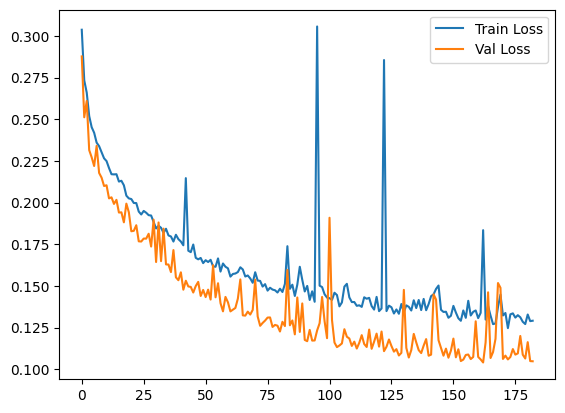

<Figure size 640x480 with 0 Axes>

In [8]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.show()
plt.savefig('history/{}/loss_plot.png'.format(timestr))


In [9]:
model.eval()
X_test_tensor = torch.tensor(X_embeddings_test, dtype=torch.float32).to(device)
with torch.no_grad():
    y_pred_test = model(X_test_tensor).cpu().numpy()
y_pred_test = postprocess_output(y_pred_test)  # If needed

event_metrics = EventBasedMetrics(event_label_list=settings.CLASS_NAMES, t_collar=params.PATCH_WINDOW_SECONDS)
segment_metrics = SegmentBasedMetrics(event_label_list=settings.CLASS_NAMES, time_resolution=params.PATCH_WINDOW_SECONDS)

predicted_event_list_10 = predictions_to_event_list(y_pred_test)
reference_event_list_10 = predictions_to_event_list(y_test)

event_metrics.evaluate(predicted_event_list_10, reference_event_list_10)
segment_metrics.evaluate(predicted_event_list_10, reference_event_list_10)

print_metrics(event_metrics.results(), "Event-based")
print_metrics(segment_metrics.results(), "Segment-based")





Event-based
  F1: 0.968 | Precision: 0.955 | Recall: 0.982
  Error Rate: 0.064
  Class-wise F1:
    Aircraft: 0.968

Segment-based
  F1: 0.944 | Precision: 0.930 | Recall: 0.957
  Error Rate: 0.114
  Accuracy: 0.900
  Class-wise F1:
    Aircraft: 0.944
